### Introducción

En el presente trabajo nos dispondremos a emplear redes neuronales no supervisadas sobre el mismo conjunto de datos para una tarea de clasificación.

1. En primer lugar, reduciremos la dimensionalidad del dataset. Para ello utilizaremos dos estrategias: Oja general y Sanger. Estos métodos difieren en que dicha reducción de la dimensionalidad resulte en que la matriz de pesos sea el subespacio que genera las K componentes principales, cuya mayor varianza conservan, o bien SEAN las K componentes principales, respectivamente.

2. Por otro lado, otro objetivo de este trabajo es la clusterización del dataset. Mediante mapas auto-organizados, usando de redes neuronales de Kohonen y una cierta noción de cercanía, clusterizaremos topológicamente los datos.

###Exploración de datos

En esta sección, una breve exploración de datos.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

import requests

r = requests.get("https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv")
data = np.loadtxt(r.iter_lines() , delimiter = ",")

data.shape

(900, 857)

(array([695.,  66.,  25.,  15.,  13.,   8.,   6.,   3.,   6.,   3.,   1.,
          2.,   0.,   2.,   1.,   3.,   2.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.]),
 array([  0.        ,   6.21666667,  12.43333333,  18.65      ,
         24.86666667,  31.08333333,  37.3       ,  43.51666667,
         49.73333333,  55.95      ,  62.16666667,  68.38333333,
         74.6       ,  80.81666667,  87.03333333,  93.25      ,
         99.46666667, 105.68333333, 111.9       , 118.11666667,
        124.33333333, 130.55      , 136.76666667, 142.98333333,
        149.2       , 155.41666667, 161.63333333, 167.85      ,
        174.06666667, 180.28333333, 186.5       , 192.71666667,
        198.93333333, 205.15      , 211.36666667, 217.58333333,
        223.8 

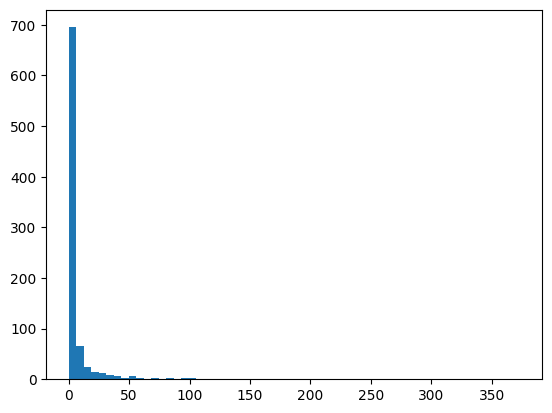

In [ ]:

targets = data[:,0]
x = data[:,1:]
plt.hist(np.sum(x , axis = 0), bins =60)#sumatoria de apariciones de la palabra

De este gráfico lo que se observa es que muchas palabras no están compartidas entre varias industrias, ya que se desprende de la sumatoria de apariciones de esta por columna, es decir, en el eje x se observa de menor a mayor la aparición de palabras.

Esto va en favor de uno de nuestros objetivos, que es clusterizar de manera topológica los datos.

###Reducción de dimensiones

En la presente sección vamos a reducir la dimensionalidad del problema a 9 dimensiones, empleando redes neuronales que utilicen las reglas de Oja General y Sanger, como metodologías diferentes, para satisfacer tal fin.

In [ ]:
#normalizamos el dataset
x_norm = (x - x.mean(axis=0)) / x.std()

####Funciones a utilizar

Primero definimos las funciones que vamos a utilizar en esta parte.

La única diferencia entre las funciones de OjaGral y Sanger va a estar en la definición de la corrección **dw** de los pesos.

Se interrumpe el apredizaje cuando se alcance el número máximo de épocas o cuando el valor de ortogonalidad de la matriz de pesos sea menor al criterio elegido.

A su vez, el factor de aprendizaje **lr** será reducido cada 1000 épocas.

In [ ]:
def OjaGral(dataset , dim_final , lr = 0.001 , criterio = 0.01, epocas = 3000):

    x = np.zeros((1,dataset.shape[1]))
    d_w = np.zeros((dataset.shape[1] , dim_final))
    w = np.random.uniform(-0.1, 0.1, size=(dataset.shape[1], dim_final))
    y = np.zeros((1 , dim_final))
    epochs = 0
    ortogonalidad = np.sum( np.abs(np.dot(w.T, w) - np.identity(dim_final) )) / 2

    while (epochs < epocas and ortogonalidad > criterio):

        index = np.random.permutation(x.shape[0])

        for i in index:
            x[:] = dataset[i , :]
            y[:] = np.dot(x , w)
            z = np.dot(y , w.T)
            d_w = np.outer( (x-z) , y )
            w += lr * d_w

        ortogonalidad = np.sum( np.abs(np.dot(w.T, w) - np.identity(dim_final) )) / 2
        epochs += 1

        #reducimos el lr cada 1000 epocas
        if epochs % 1000 == 0:
            lr *= 0.2

    print("ortogonalidad: ", ortogonalidad)
    print("epocas: ", epochs)

    return w


#############################################################################

def Sanger(dataset , dim_final , lr = 0.001 , criterio = 0.01, epocas = 3000):

    diag = np.triu( np.ones((dim_final,dim_final)))
    x = np.zeros((1,dataset.shape[1]))
    d_w = np.zeros((dataset.shape[1] , dim_final))
    w = np.random.uniform(-0.1 , 0.1, size=(dataset.shape[1], dim_final))
    y = np.zeros((1 , dim_final))
    epochs = 0
    ortogonalidad = np.sum( np.abs(np.dot(w.T, w) - np.identity(dim_final) )) / 2

    while (epochs < epocas and ortogonalidad > criterio):

        index = np.random.permutation(x.shape[0])

        for i in index:
            x[:] = dataset[i , :]
            y[:] = np.dot(x , w)
            z = np.dot(w, y.T*diag)
            d_w = (x.T-z) * y
            w += lr * d_w

        ortogonalidad = np.sum( np.abs(np.dot(w.T, w) - np.identity(dim_final) )) / 2
        epochs += 1

        #reducimos el lr cada 1000 epocas
        if epochs % 100 == 0:
            lr *= 0.2

    print("ortogonalidad: ", ortogonalidad)
    print("epocas: ", epochs)

    return w


 #############################################################################

def graficar_componentes_principales(Y_pred, target):

    #grafica las 9 primeras componentes principales en tres graficos 3D.

    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Componentes principales', y = 0.8)
    #1
    primeras_tres_componentes = fig.add_subplot(131, projection='3d')
    primeras_tres_componentes.scatter3D(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], c=target)
    #2
    segundas_tres_componentes = fig.add_subplot(132, projection='3d')
    segundas_tres_componentes.scatter3D(Y_pred[:,3], Y_pred[:,4], Y_pred[:,5], c=target)
    #3
    terceras_tres_componentes = fig.add_subplot(133, projection='3d')
    terceras_tres_componentes.scatter3D(Y_pred[:,6], Y_pred[:,7], Y_pred[:,8], c=target)

    fig.show()

####Oja General

Entrenamos el modelo, obtenemos los pesos y luego las primeras 9 componentes principales del dataset.

Ponemos un learning-rate bajo porque si no hay problemas numéricos a las pocas épocas.

In [ ]:
%%time
#calculamos los pesos del modelo
W_oja = OjaGral(x_norm , 9 , lr = 0.001 , criterio = 0.01, epocas = 300)

#pesos de las primeras 9 componentes principales de cada entrada
Y_oja = np.dot(x_norm, W_oja)

ortogonalidad:  13.515723586735096
epocas:  300
CPU times: user 69.6 ms, sys: 0 ns, total: 69.6 ms
Wall time: 74.3 ms


El entrenamiento se termina por alcanzar el número de épocas. No estamos satisfechos con los factores de ortogonalidad que arroja el modelo en varias instancias.

Graficamos las primeras 9 componentes principales.

Las figuras se corresponden a:
* izquierda: primeras tres componentes principales;
* medio: segundas tres componentes principales;
* derecha: terceras tres componentes principales.

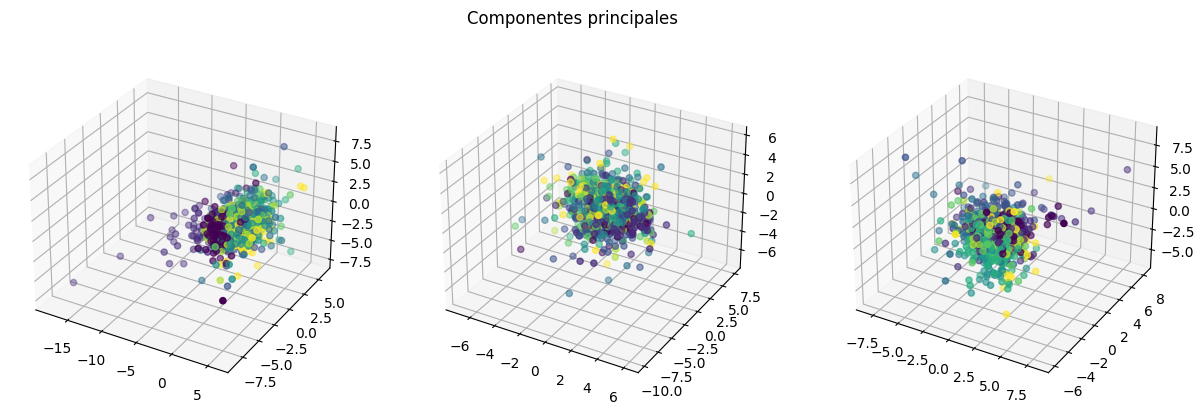

In [ ]:
graficar_componentes_principales(Y_oja, targets)

En la figura de la izquierda puede observarse que los elementos de la categoría azul/violeta quedaron más o menos agrupados. Para el resto de las categorías (color) resulta más complicado diferenciarlas en clusters.

####Sanger

Entrenamos el modelo, obtenemos los pesos y luego las primeras 9 componentes principales del dataset.

Ponemos un learning-rate bajo porque si no hay problemas numéricos a las pocas épocas.

In [ ]:
%%time
#calculamos los pesos del modelo
W_sanger = Sanger(x_norm , 9 , lr = 0.001 , criterio = 0.001, epocas = 150)

#pesos de las primeras 9 componentes principales de cada entrada
Y_sanger = np.dot(x_norm, W_sanger)

ortogonalidad:  6.839331587566923
epocas:  150
CPU times: user 37.5 ms, sys: 2.9 ms, total: 40.4 ms
Wall time: 115 ms


Nuevamente el entrenamiento se termina por alcanzar el número de épocas. A pesar de dar un factor de ortogonalidad menor al de Oja General, seguimos sin estar satisfechos. Tampoco vemos mejoras en un mayor número de épocas.

Ahora graficamos las primeras 9 componentes principales.

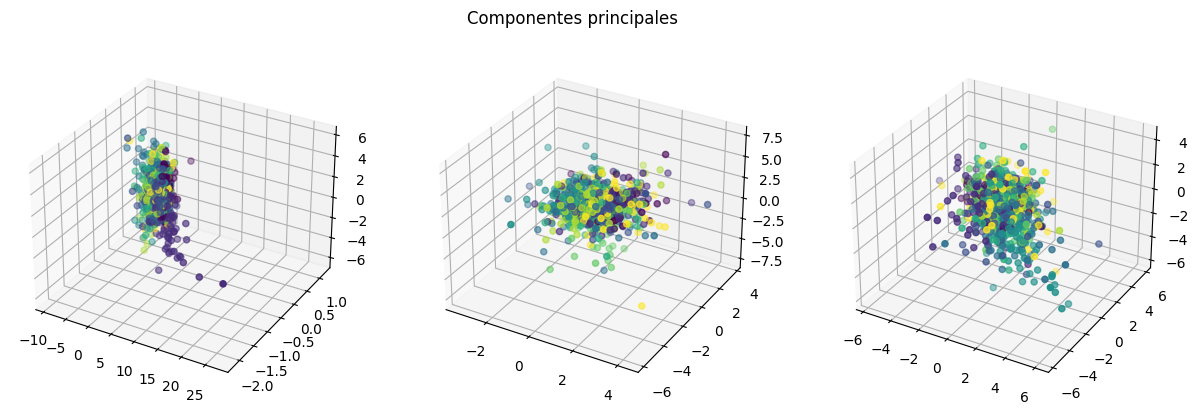

In [ ]:
graficar_componentes_principales(Y_sanger, targets)

En este modelo no se logra diferenciar muy claramente las distintas categorías. Hay sectores más oscuros y otros más claros, pero no es tan evidente.

####Conclusión

Los resultados obtenidos no son satisfactorios ya que tanto el modelo de Oja como el de Sanger no convergen. Aumentar las épocas no parece mejorar la situación, por lo que el problema está en otro lado.

## 2.2. Mapeo de características
Construir un modelo de mapeo de características auto-organizado que clasifique automáticamente
los documentos en un arreglo de dos dimensiones. Tener en cuenta que para poder realizar una buena
clasificación se debe contar con suficientes unidades de salida y con suficientes instancias de datos por
unidad.
Se recomienda experimentar entrenando distintos modelos, por ejemplo variando la cantidad de unidades de salida y los parámetros adaptativos utilizados en el aprendizaje, para tratar de obtener una buena
solución.
Una vez realizado el entrenamiento representar gráficamente en un mapa de características los resultados, señalando para cada unidad de salida cuál es la categoría que más la activa (por ejemplo con
distintos colores).


Definimos las funciones que vamos a utilizar.

In [ ]:
def AutoOrga(dataset , M, w= None, lr_ini = 1 , lr_decay = 0.1 , radio_ini = 3 , radio_decay = 0.05, epochs = 10):

    N = dataset.shape[1]
    if w is None:
        w = np.random.normal( 0,1, (M,M,N))

    coord = [[(i,j) for j in range(M)] for i in range(M)]
    mat_coord = np.array(coord)

    for t in range(1,epochs):

        for h in range(0 , dataset.shape[0]):

            x = dataset[h]

            error = x-w

            norma = np.linalg.norm( error, axis=2)

            pos = np.unravel_index( np.argmin( norma), norma.shape)

            lr = lr_ini * np.exp( -t * lr_decay)

            radio = radio_ini * np.exp( -t * radio_decay)

            dist = np.linalg.norm( mat_coord - pos, axis=2)

            func_prox = np.exp( -dist / (2*np.square(radio))).reshape((M,M,1)) #el problema es dist

            dw = lr * func_prox * error

            w += dw

    return w

def mapeo(w , x_pruebas, targets):

    tensor = np.zeros((w.shape[0] , w.shape[0] , x_pruebas.shape[0]))
    clases_ten = np.zeros((w.shape[0] , w.shape[0] , x_pruebas.shape[0]))
    y = np.zeros((w.shape[0],w.shape[0]))

    for h in range(0 , x_pruebas.shape[0]):

        error = x_pruebas[h,:] - w

        norma = np.linalg.norm( error, axis=2)

        pos = np.unravel_index( np.argmin( norma), norma.shape)

        y[:] *= 0

        y[pos] = 1

        tensor[:,:,h] = y

        clases_ten[pos[0],pos[1],h] = targets[h]

    return tensor, clases_ten


In [ ]:
def winner_class_plot(clases_ten):
    winning_class = np.zeros((15, 15), dtype=int)
    for i in range(15):
        for j in range(15):
            counts = np.bincount(clases_ten[i, j].astype(int))
            counts[0] = 0  # Set count of class 0 to 0
            winning_class[i, j] = np.argmax(counts)
    print(winning_class)
    plt.imshow(winning_class, cmap="tab10")
    plt.colorbar(ticks=range(0, 9))

    plt.show()

Learning-rate y radio de influencia con decrecimiento exponencial:

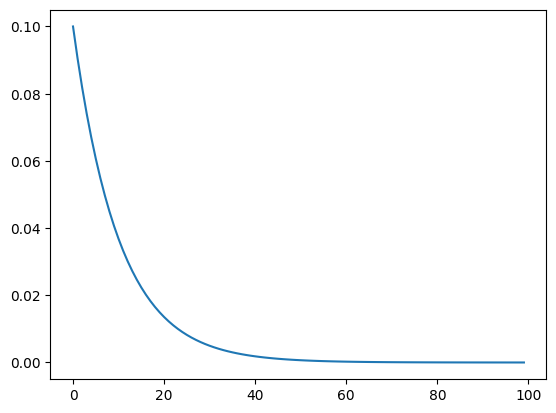

In [ ]:
# Para 100 epocas.
t = np.arange(100)
# El Coeficiente de Aprendizaje...
# decae exponencialmente.
lr_st = 0.1
lr_dr = 0.1
lr = lr_st * np.exp( -t * lr_dr)
plt.plot( t, lr)
plt.show()


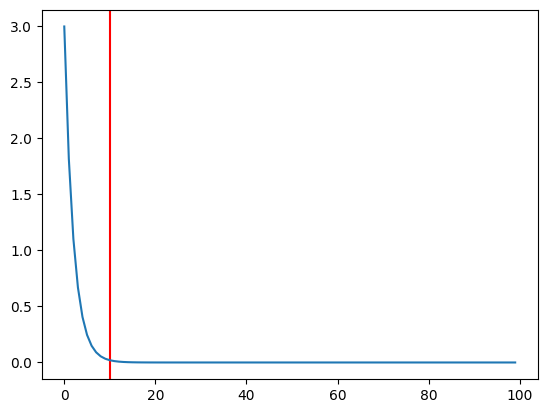

In [ ]:
# Igual que el...
# Radio de Influencia.
ir_st = 3
ir_dr = 0.5
ir = ir_st * np.exp( -t * ir_dr)
plt.axvline(x=10, color="red")
plt.plot( t, ir)
plt.show()

# Entrenamiento
Se probo con los datos con y sin normalizar (Z-score).

## Parametros
Para entrenar elegimos una matris de 22x22 dado que proporciona un equilibrio razonable entre la captura de patrones complejos y la eficiencia computacional.
Para la primera etapa de entrenamiento, etapa de **organización**, definimos un radio grande (en relacion a las 30x30 neuronas) y un learning rate grande. Comenzamos con 100 epochs.

### Etapa de **Organización**

In [ ]:
%%time
#Entrenamiento sin normalizar
w1 = AutoOrga(x , 22, lr_ini = 0.5 , lr_decay = 0.01 , radio_ini = 15 , radio_decay = 0.5, epochs = 100)

#Test with normalization
w_norm = AutoOrga(x_norm , 22 , lr_ini = 0.5 , lr_decay = 0.01 , radio_ini = 15 , radio_decay = 0.5, epochs = 100)

CPU times: user 6min 18s, sys: 706 ms, total: 6min 18s
Wall time: 6min 32s


In [ ]:
#La funcion "mapeo" calcula cada matrices con el 1 en la neurona ganadora
#para cada muestra, devolviendo "mapa" (ceros y 1) y clases_ten (ceros y
#clase [1-7] en lugar del 1)
mapa, clases_ten = mapeo(w1 , x, targets)
class_distribution = mapa.sum(axis=2)
#Normalizado
mapa_norm, clases_ten_norm = mapeo(w_norm , x_norm, targets)
class_distribution_norm = mapa_norm.sum(axis=2)

Como se ve en los gráficos, con los datos no normalizados tenemos una activación más uniforme de las neuronas.

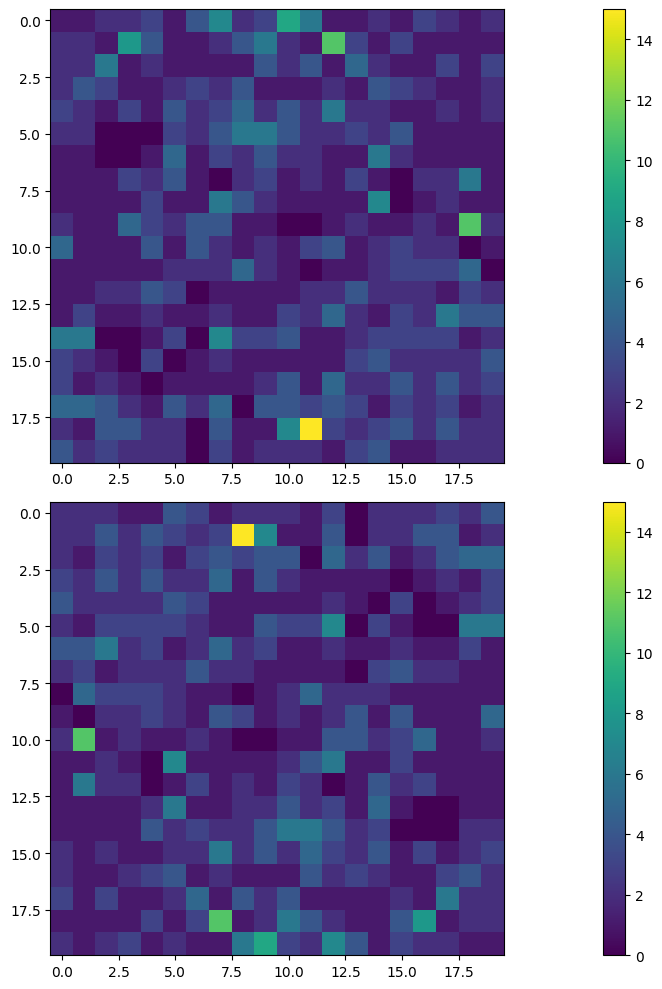

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot data on the first subplot
im1 = ax1.imshow(class_distribution, label='Data')
fig.colorbar(im1, ax=ax1)

# Plot data on the second subplot
im2 = ax2.imshow(class_distribution_norm, label='normalized data')
fig.colorbar(im2, ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

El mapa luego de la organización presenta las neuronas uniformemente activadas.
El mapa normalizado no parece organizarse mejor, dado que todas las catagorias son del mismo tipo, nos parece que no es necesaria la normalizacion.
Se puede ver como se separan las diferentes categorias en pequeños cúmulos, diferencialmente distribuidos a lo largo de las red.

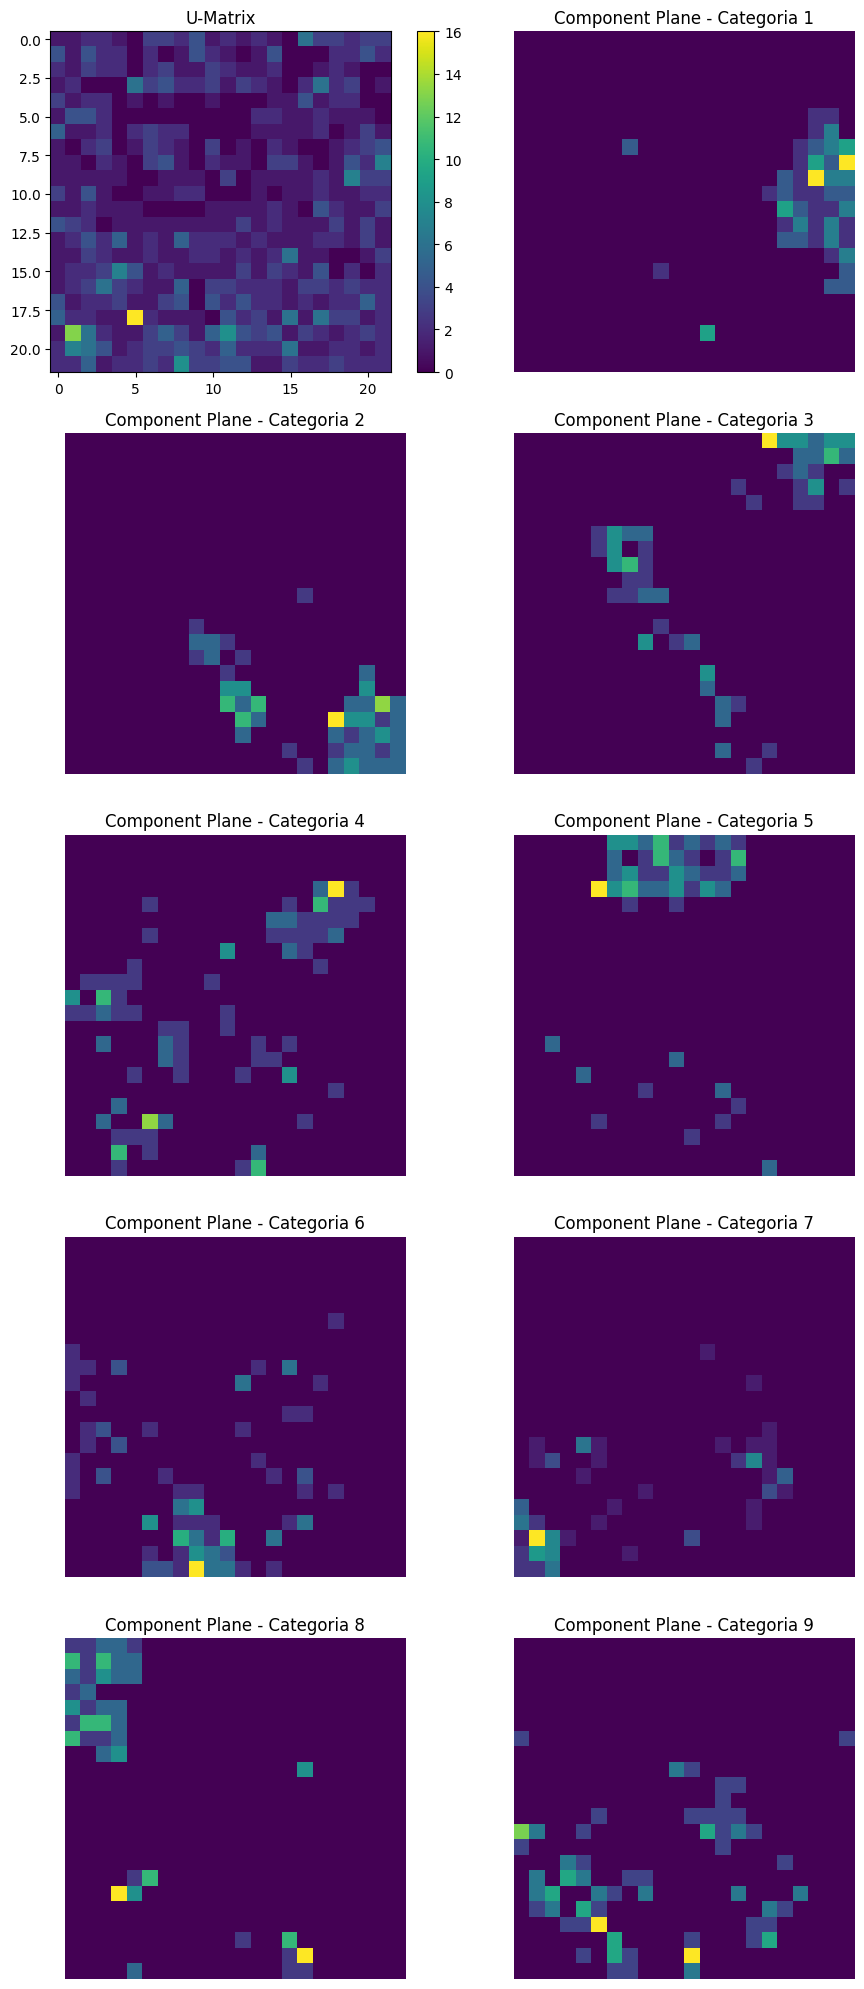

[[8 8 8 8 8 0 5 5 5 5 5 5 5 5 5]
 [8 8 8 8 8 0 5 0 5 5 5 5 0 5 5]
 [8 8 8 8 8 0 5 5 5 5 5 5 5 5 5]
 [8 8 0 0 0 5 5 5 5 5 5 5 5 5 3]
 [8 8 8 8 0 4 0 5 0 0 5 0 0 0 4]
 [8 8 8 8 0 0 0 0 0 0 0 0 0 4 4]
 [8 8 8 8 0 3 3 3 3 0 0 0 0 4 4]
 [6 0 8 8 0 3 3 1 3 0 4 0 7 0 4]
 [6 6 0 6 4 0 3 3 3 0 9 9 6 0 6]
 [6 4 4 4 4 0 0 3 3 4 0 6 0 9 9]
 [4 6 4 4 0 0 3 3 3 3 0 0 0 9 0]
 [4 4 4 4 4 9 0 0 0 0 4 9 9 9 6]
 [9 9 6 0 9 6 4 4 2 3 4 6 9 9 9]
 [9 6 4 6 7 7 4 4 3 2 2 3 4 7 4]
 [6 7 7 9 9 7 4 4 2 2 5 2 4 4 7]]


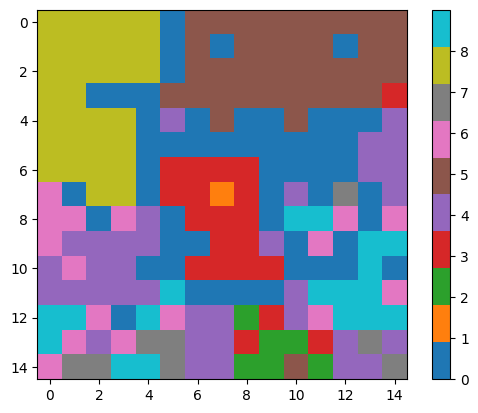

In [ ]:

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# U-Matrix
umatrix = class_distribution
im = axes[0,0].imshow(umatrix, cmap='viridis')  # Use a suitable colormap
axes[0,0].set_title('U-Matrix')

# Component Planes
num_categories = 9
component_planes = np.zeros((num_categories, w1.shape[0], w1.shape[1]))
for category in range(1, num_categories + 1):
    indices = np.where(targets == category)[0]
    for index in indices:
        x_plot, y_plot = np.unravel_index(np.argmax(mapa[:, :, index]), w1.shape[:2])
        component_planes[category - 1, x_plot, y_plot] += 1

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(component_planes[i], cmap='viridis')  # Use a suitable colormap
    ax.set_title(f'Component Plane - Categoria {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.colorbar(im, ax=axes[0,0])
plt.show()

# Scatter Plot
winner_class_plot(clases_ten)

### **Consolidación**
Para esta etapa utilizamos parametros de entrenamiento menores para ajustar finamente el mapa. Dedicimos seguir con los datos sin normalizar. Los decay_rates son mas altos, para suavizar más aún el proceso de consolidación.


In [ ]:
w2_1 = AutoOrga(x , 22, w1, lr_ini = 0.01 , lr_decay = 0.1 , radio_ini = 2 , radio_decay = 0.5, epochs = 300)

Se observa que las regiones con una misma categoría suelen estar agrupadas en conjuntos.

In [ ]:
mapa2_1, clases_ten2_1 = mapeo(w2_1 , x, targets)

class_distribution2_1 = mapa2_1.sum(axis=2)

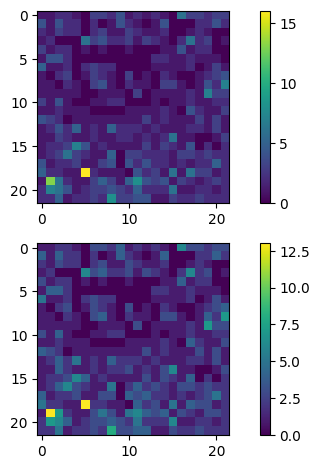

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot data on the first subplot
im1 = ax1.imshow(class_distribution, label='Data')
fig.colorbar(im1, ax=ax1)

# Plot data on the second subplot
im2 = ax2.imshow(class_distribution2_1, label='training in 2 steps')
fig.colorbar(im2, ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

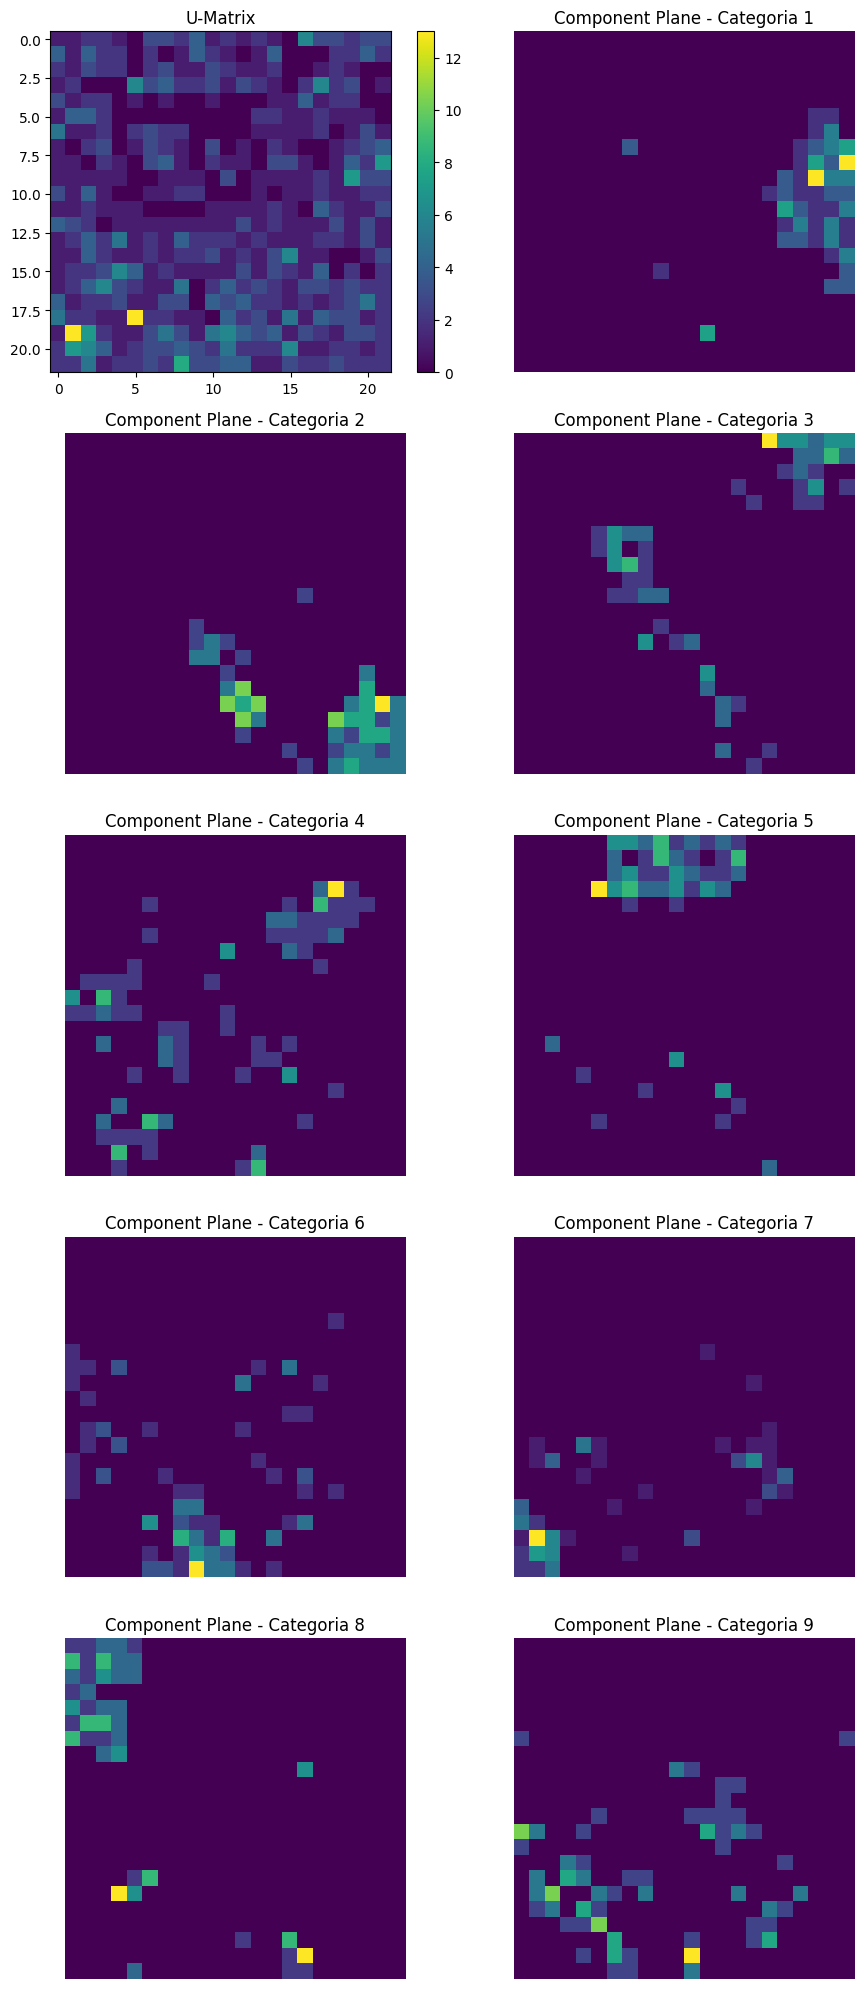

[[8 8 8 8 8 0 5 5 5 5 5 5 5 5 5]
 [8 8 8 8 8 0 5 0 5 5 5 5 0 5 5]
 [8 8 8 8 8 0 5 5 5 5 5 5 5 5 5]
 [8 8 0 0 0 5 5 5 5 5 5 5 5 5 3]
 [8 8 8 8 0 4 0 5 0 0 5 0 0 0 4]
 [8 8 8 8 0 0 0 0 0 0 0 0 0 4 4]
 [8 8 8 8 0 3 3 3 3 0 0 0 0 4 4]
 [6 0 8 8 0 3 3 1 3 0 4 0 7 0 4]
 [6 6 0 6 4 0 3 3 3 0 9 9 6 0 6]
 [6 4 4 4 4 0 0 3 3 4 0 6 0 9 9]
 [4 6 4 4 0 0 3 3 3 3 0 0 0 9 0]
 [4 4 4 4 4 9 0 0 0 0 4 9 9 9 6]
 [9 9 6 0 9 6 4 4 2 3 4 6 9 9 9]
 [9 6 4 6 7 7 4 4 3 2 2 3 4 7 4]
 [6 7 7 9 9 7 4 4 2 2 5 2 4 4 7]]


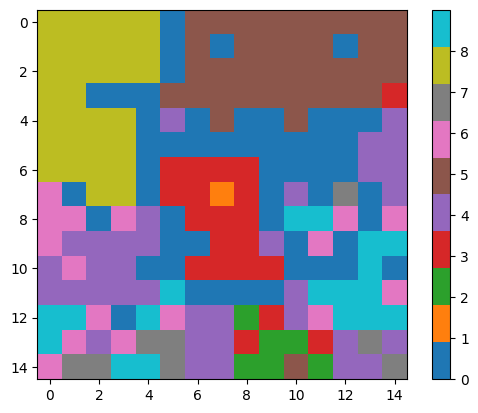

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# U-Matrix
umatrix = class_distribution2_1
im = axes[0,0].imshow(umatrix, cmap='viridis')  # Use a suitable colormap
axes[0,0].set_title('U-Matrix')

# graficos por componente
num_categories = 9
component_planes = np.zeros((num_categories, w2_1.shape[0], w2_1.shape[1]))
for category in range(1, num_categories + 1):
    indices = np.where(targets == category)[0]
    for index in indices:
        x_plot, y_plot = np.unravel_index(np.argmax(mapa2_1[:, :, index]), w2_1.shape[:2])
        component_planes[category - 1, x_plot, y_plot] += 1

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(component_planes[i], cmap='viridis')  # Use a suitable colormap
    ax.set_title(f'Component Plane - Categoria {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.colorbar(im, ax=axes[0,0])
plt.show()

# Scatter Plot de la clase ganadora por neurona
winner_class_plot(clases_ten2_1)


2do Intentamos con decay_rates menores. Esto permite un refuerzo mayor, intentando buscar una mejor separación de los datos.


In [ ]:
w2_2 = AutoOrga(x , 22, w1, lr_ini = 0.01 , lr_decay = 0.05 , radio_ini = 2 , radio_decay = 0.1, epochs = 500)

In [ ]:
mapa2_2, clases_ten2_2 = mapeo(w2_2 , x, targets)

class_distribution2_2 = mapa2_2.sum(axis=2)

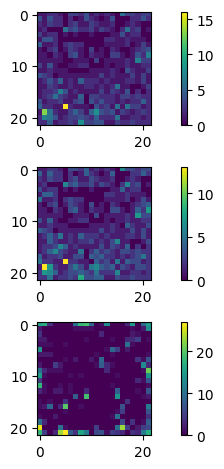

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plot data on the first subplot
im1 = ax1.imshow(class_distribution, label='Data')
fig.colorbar(im1, ax=ax1)

# Plot data on the second subplot
im2 = ax2.imshow(class_distribution2_1, label='training in 2 steps')
fig.colorbar(im2, ax=ax2)

# Plot data on the second subplot
im3 = ax3.imshow(class_distribution2_2, label='training in 2 steps (smaller params)')
fig.colorbar(im3, ax=ax3)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

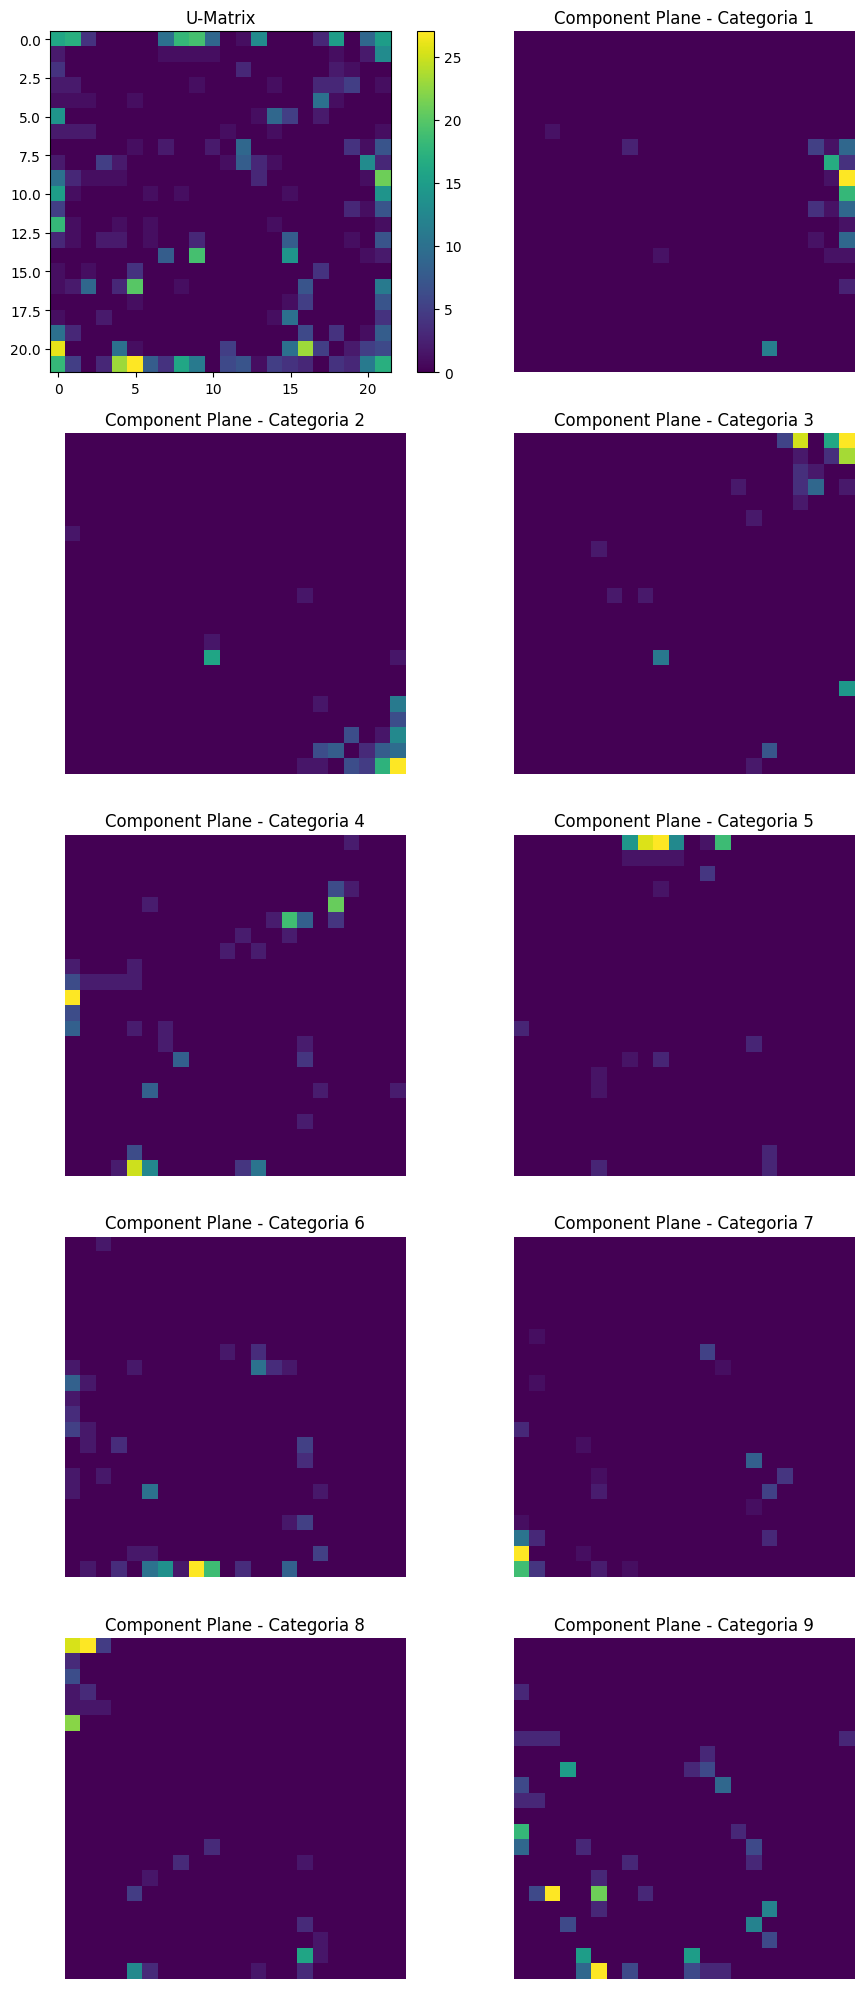

[[8 8 8 0 0 0 0 5 5 5 5 0 5 5 0]
 [8 0 0 0 0 0 0 5 5 5 5 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [8 8 0 0 0 0 0 0 0 5 0 0 0 0 3]
 [8 8 8 0 0 4 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0 0 0 0 4 4]
 [2 7 1 0 0 0 0 0 0 0 0 4 0 0 4]
 [0 0 0 0 0 3 0 1 0 0 4 0 7 0 0]
 [4 0 0 9 4 0 0 0 0 0 0 9 6 6 6]
 [6 4 4 4 4 0 0 0 0 0 0 0 0 9 0]
 [4 9 0 0 0 0 3 0 3 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 6 0 0 4 0 4 0 0 0 0 0 0 0 9]
 [9 6 0 6 7 0 4 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 2 0 0 0 0 0]]


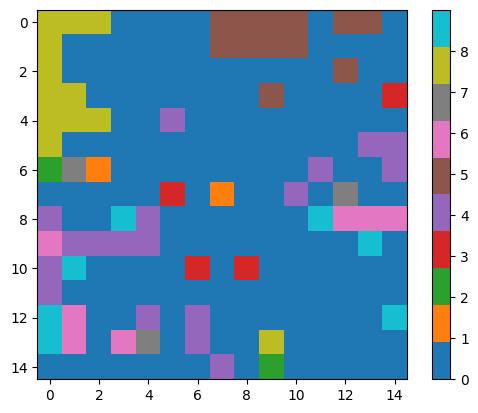

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# U-Matrix
umatrix = class_distribution2_2
im = axes[0,0].imshow(umatrix, cmap='viridis')  # Use a suitable colormap
axes[0,0].set_title('U-Matrix')

# graficos por componente
num_categories = 9
component_planes = np.zeros((num_categories, w2_2.shape[0], w2_2.shape[1]))
for category in range(1, num_categories + 1):
    indices = np.where(targets == category)[0]
    for index in indices:
        x_plot, y_plot = np.unravel_index(np.argmax(mapa2_2[:, :, index]), w2_2.shape[:2])
        component_planes[category - 1, x_plot, y_plot] += 1

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(component_planes[i], cmap='viridis')  # Use a suitable colormap
    ax.set_title(f'Component Plane - Categoria {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.colorbar(im, ax=axes[0,0])
plt.show()

# Scatter Plot de la clase ganadora por neurona
winner_class_plot(clases_ten2_2)

## Otras pruebas de parámetros.
Decidimos cambiar los parametros iniciales. Primero probamos cambiar la cantidad de neuronas.

In [ ]:
w1_2 = AutoOrga(x , 12, lr_ini = 1 , lr_decay = 0.1 , radio_ini = 8 , radio_decay = 0.5, epochs = 100)


In [ ]:
w2_3 = AutoOrga(x , 12, w1_2, lr_ini = 0.01 , lr_decay = 0.1 , radio_ini = 0.1 , radio_decay = 0.5, epochs = 500)

In [ ]:
mapa1_2, clases_ten1_2 = mapeo(w1_2 , x, targets)
class_distribution1_2 = mapa1_2.sum(axis=2)

mapa2_3, clases_ten2_3 = mapeo(w2_3 , x, targets)
class_distribution2_3 = mapa2_3.sum(axis=2)

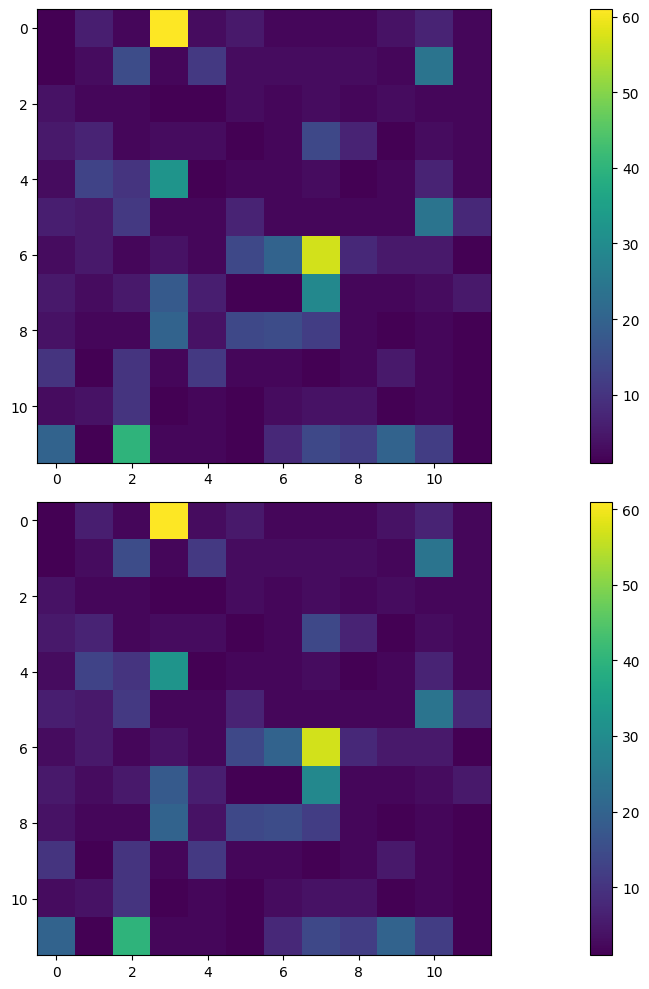

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot data on the first subplot
im1 = ax1.imshow(class_distribution1_2, label='Mapa Organizado de 12x12')
fig.colorbar(im1, ax=ax1)

# Plot data on the second subplot
im2 = ax2.imshow(class_distribution2_3, label='Mapa consolidado de 12x12')
fig.colorbar(im2, ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

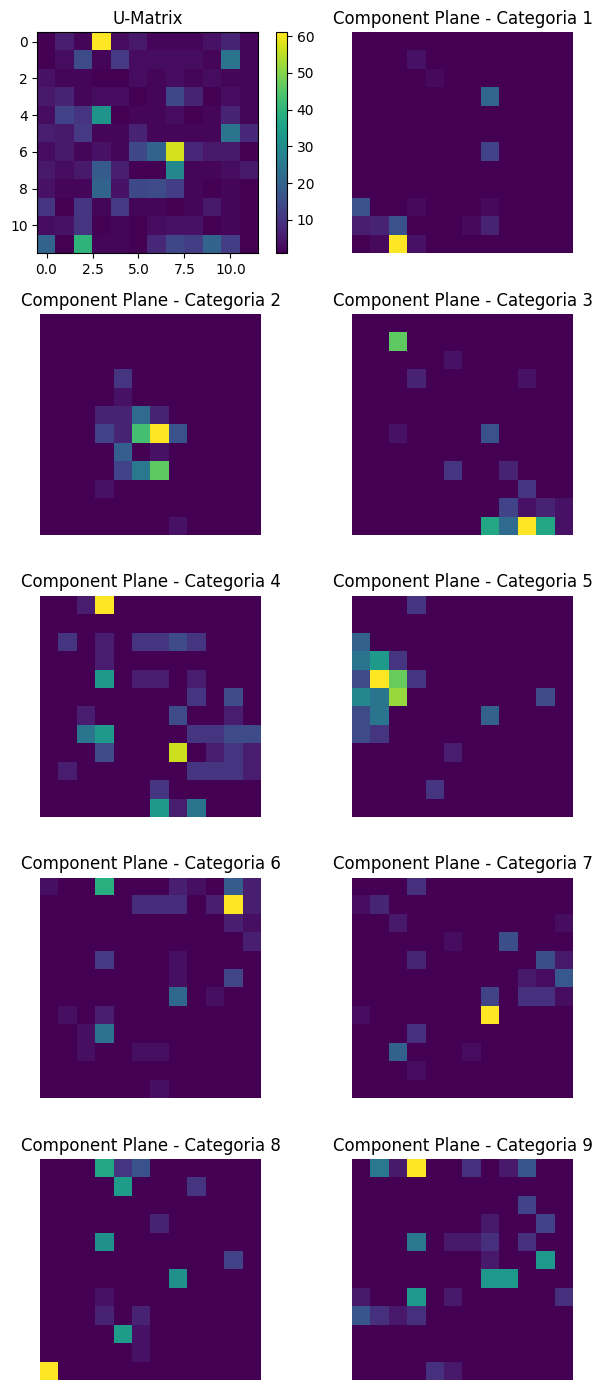

ValueError: ignored

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7, 14))

# U-Matrix
umatrix = class_distribution2_3
im = axes[0,0].imshow(umatrix, cmap='viridis')  # Use a suitable colormap
axes[0,0].set_title('U-Matrix')

# Component Planes
num_categories = 9
component_planes = np.zeros((num_categories, w2_3.shape[0], w2_3.shape[1]))
for category in range(1, num_categories + 1):
    indices = np.where(targets == category)[0]
    for index in indices:
        x_plot, y_plot = np.unravel_index(np.argmax(mapa2_3[:, :, index]), w2_3.shape[:2])
        component_planes[category - 1, x_plot, y_plot] += 1

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(component_planes[i], cmap='viridis')  # Use a suitable colormap
    ax.set_title(f'Component Plane - Categoria {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.colorbar(im, ax=axes[0,0])
plt.show()

# Scatter Plot de la clase ganadora por neurona
x_coords, y_coords = np.unravel_index(np.argmax(mapa2_3, axis=2), (12, 12))  # Adjust the shape of the unravel_index function
plt.scatter(x_coords, y_coords, c=targets, cmap='viridis')  # Use a suitable colormap
plt.colorbar()
plt.title('SOM Scatter Plot')
plt.show()


## Mezclando ambas partes del TP
Intentamos generar un mapa autoorganizado utilizando la descomposición de Sanger

In [ ]:
w_red_dim = AutoOrga(Y_sanger , 15, lr_ini = 0.5 , lr_decay = 0.1 , radio_ini = 9 , radio_decay = 0.5, epochs = 100)

In [ ]:
w_red_dim2 = AutoOrga(Y_sanger , 15, w_red_dim, lr_ini = 0.01 , lr_decay = 0.1 , radio_ini = 0.1 , radio_decay = 0.5, epochs = 500)

In [ ]:
mapa_red_dim, clases_ten_red_dim = mapeo(w_red_dim , Y_sanger, targets)
class_distribution_red_dim = mapa_red_dim.sum(axis=2)

mapa_red_dim_2, clases_ten_red_dim_2 = mapeo(w_red_dim2 , Y_sanger, targets)
class_distribution_red_dim_2 = mapa_red_dim_2.sum(axis=2)

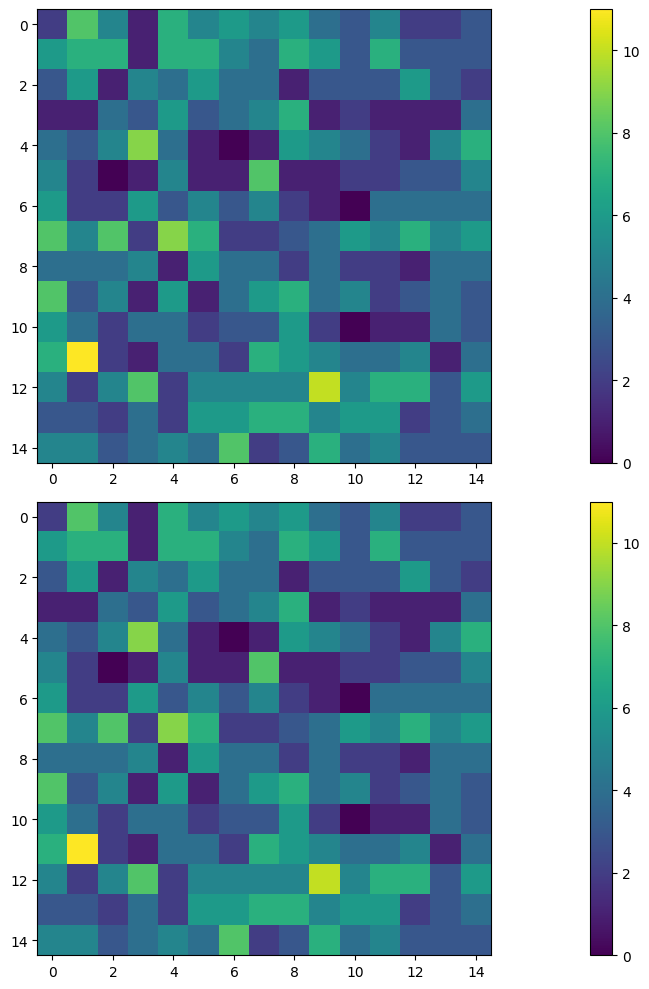

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot data on the first subplot
im1 = ax1.imshow(class_distribution_red_dim, label='Mapa Organizado de 12x12')
fig.colorbar(im1, ax=ax1)

# Plot data on the second subplot
im2 = ax2.imshow(class_distribution_red_dim_2, label='Mapa consolidado de 12x12')
fig.colorbar(im2, ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

En ambas etapas, organización y consolidación, se ve una activación uniforme de las neuronas.

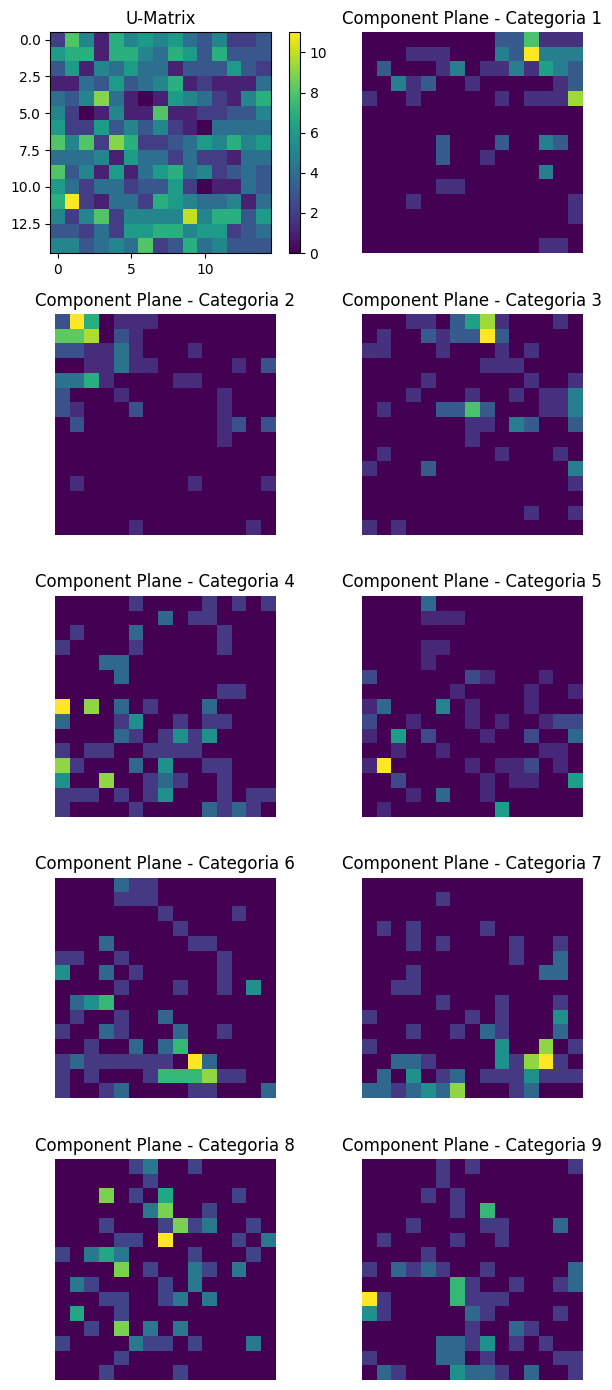

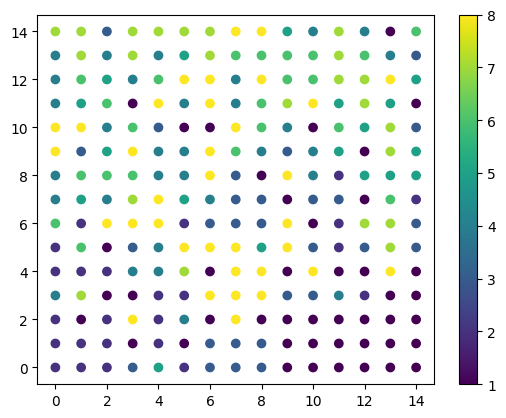

TypeError: ignored

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7, 14))

# U-Matrix
umatrix = class_distribution_red_dim_2
im = axes[0,0].imshow(umatrix, cmap='viridis')  # Use a suitable colormap
axes[0,0].set_title('U-Matrix')

# Component Planes
num_categories = 9
component_planes = np.zeros((num_categories, w_red_dim2.shape[0], w_red_dim2.shape[1]))
for category in range(1, num_categories + 1):
    indices = np.where(targets == category)[0]
    for index in indices:
        x_plot, y_plot = np.unravel_index(np.argmax(mapa_red_dim_2[:, :, index]), w_red_dim2.shape[:2])
        component_planes[category - 1, x_plot, y_plot] += 1

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(component_planes[i], cmap='viridis')  # Use a suitable colormap
    ax.set_title(f'Component Plane - Categoria {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.colorbar(im, ax=axes[0,0])
plt.show()

# Scatter Plot de la clase ganadora por neurona

winner_class_plot(clases_ten_red_dim_2)

Se logra cierta separación entre las clases. Si bien no logramos disminuir lo suficiente la ortogonalidad en la primera parte del TP, aún es posible identificar y separar las clases con un mapa autoorganizado.